In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
features_df = pd.read_parquet("data/changeset_data/osm_labelled_changeset_features_with_user_info.parquet")

In [3]:
features_df.head()

,changeset_id,created_at,closed_at,user,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,...,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,uid,account_created,changes_count
0,19739784,2014-01-01 00:16:15+00:00,2014-01-01 00:16:17+00:00,bryanpiczon,688302,3,10.376628,123.400400,10.498390,123.635174,...,True,1,2,0,1,2,0,688302,2012-05-24T12:27:56Z,0
1,19739822,2014-01-01 00:21:49+00:00,2014-01-01 00:21:51+00:00,bryanpiczon,688302,13,10.376457,123.633181,10.390640,123.640732,...,True,10,3,0,12,1,0,688302,2012-05-24T12:27:56Z,0
2,19740673,2014-01-01 03:44:23+00:00,2014-01-01 03:44:25+00:00,bryanpiczon,688302,21,9.749016,124.004176,10.410474,125.187905,...,True,17,4,0,21,0,0,688302,2012-05-24T12:27:56Z,0
3,19740747,2014-01-01 04:12:07+00:00,2014-01-01 04:12:09+00:00,bryanpiczon,688302,10,9.783770,125.079765,10.766378,125.929561,...,True,8,2,0,8,2,0,688302,2012-05-24T12:27:56Z,0
4,19740824,2014-01-01 04:36:01+00:00,2014-01-01 04:36:08+00:00,bryanpiczon,688302,13,9.796782,125.077679,10.712891,125.838949,...,True,11,2,0,12,1,0,688302,2012-05-24T12:27:56Z,0


In [70]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('changeset_id'):
    features_df.drop('changeset_id', axis=1, inplace=True)

if features_df.columns.__contains__('created_at'):
    features_df.drop('created_at', axis=1, inplace=True)

if features_df.columns.__contains__('user'):
    features_df.drop('user', axis=1, inplace=True)
    
if features_df.columns.__contains__('comment'):
    features_df.drop('comment', axis=1, inplace=True)

if features_df.columns.__contains__('uid'):
    features_df.drop('uid', axis=1, inplace=True)

if features_df.columns.__contains__('changes_count'):
    features_df.drop('changes_count', axis=1, inplace=True)

In [71]:
features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)
features_df.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,created_by,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,account_created
0,2014-01-01 00:16:17+00:00,688302,3,10.376628,123.400400,10.498390,123.635174,iD 1.3.4,True,1,2,0,1,2,0,2012-05-24T12:27:56Z
1,2014-01-01 00:21:51+00:00,688302,13,10.376457,123.633181,10.390640,123.640732,iD 1.3.4,True,10,3,0,12,1,0,2012-05-24T12:27:56Z
2,2014-01-01 03:44:25+00:00,688302,21,9.749016,124.004176,10.410474,125.187905,iD 1.3.4,True,17,4,0,21,0,0,2012-05-24T12:27:56Z
3,2014-01-01 04:12:09+00:00,688302,10,9.783770,125.079765,10.766378,125.929561,iD 1.3.4,True,8,2,0,8,2,0,2012-05-24T12:27:56Z
4,2014-01-01 04:36:08+00:00,688302,13,9.796782,125.077679,10.712891,125.838949,iD 1.3.4,True,11,2,0,12,1,0,2012-05-24T12:27:56Z


In [72]:
X = features_df.drop('label', axis=1).copy()
X.head()
print(X.columns)

Index(['closed_at', 'user_id', 'num_changes', 'min_lat', 'min_lon', 'max_lat',
       'max_lon', 'created_by', 'no_nodes', 'no_ways', 'no_relations',
       'no_creates', 'no_modifications', 'no_deletions', 'account_created'],
      dtype='object')


In [73]:
y = features_df['label'].copy()
y.head()

0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [74]:
X["comment"].unique()

KeyError: 'comment'

In [87]:
X['closed_at'] = pd.to_datetime(X['closed_at']).astype(int) / 10**9
X['account_created'] = pd.to_datetime(X['account_created']).astype(int) / 10**9

In [88]:
X.dtypes

closed_at           float64
user_id               int64
num_changes           int64
min_lat             float64
min_lon             float64
max_lat             float64
max_lon             float64
created_by           object
no_nodes              int64
no_ways               int64
no_relations          int64
no_creates            int64
no_modifications      int64
no_deletions          int64
account_created     float64
dtype: object

In [89]:
X_encoded = pd.get_dummies(X, columns=['created_by'])
X_encoded.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,no_nodes,no_ways,no_relations,...,created_by_reverter;JOSM/1.5 (14945 uk),created_by_reverter_plugin/34977;JOSM/1.5 (15031 en),created_by_reverter_plugin/34999;JOSM/1.5 (15155 de),created_by_reverter_plugin/35084;JOSM/1.5 (15492 en),created_by_rocketdata.io,created_by_rosemary v0.3.12,created_by_rosemary v0.4.4,created_by_simple_revert.py,created_by_streetkeysmv,created_by_upload.py v. 1
0,1.388535,688302,3,10.376628,123.400400,10.498390,123.635174,1,2,0,...,False,False,False,False,False,False,False,False,False,False
1,1.388536,688302,13,10.376457,123.633181,10.390640,123.640732,10,3,0,...,False,False,False,False,False,False,False,False,False,False
2,1.388548,688302,21,9.749016,124.004176,10.410474,125.187905,17,4,0,...,False,False,False,False,False,False,False,False,False,False
3,1.388550,688302,10,9.783770,125.079765,10.766378,125.929561,8,2,0,...,False,False,False,False,False,False,False,False,False,False
4,1.388551,688302,13,9.796782,125.077679,10.712891,125.838949,11,2,0,...,False,False,False,False,False,False,False,False,False,False


In [90]:
y = y.replace(True, 1)
y = y.replace(False, 0)

In [91]:
y.dtype

dtype('int64')

In [92]:
sum(y) / len(y)

0.500905051834787

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [104]:
# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)

               Number of Samples  Number of Features
X_train shape              13673                1459
X_test shape                4558                1459
y_train shape              13673               13673
y_test shape                4558                4558


In [105]:
sum(y_train)/len(y_train)

0.5009142104878227

In [106]:
sum(y_test)/len(y_test)

0.5008775778850373

In [107]:
import xgboost as xgb

# Convert the datasets to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters with both 'aucpr' and 'accuracy'
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': ['aucpr', 'error'],  # 'error' is 1 - accuracy
    'seed': 42
}

# Set up the evaluation set
evals = [(dtest, 'eval')]

# Train the model with early stopping
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals,
                early_stopping_rounds=15, verbose_eval=True)


[0]	eval-aucpr:0.85039	eval-error:0.22532
[1]	eval-aucpr:0.86137	eval-error:0.21128
[2]	eval-aucpr:0.88083	eval-error:0.19351
[3]	eval-aucpr:0.88517	eval-error:0.18561
[4]	eval-aucpr:0.88896	eval-error:0.18627
[5]	eval-aucpr:0.89532	eval-error:0.17793
[6]	eval-aucpr:0.89931	eval-error:0.17464
[7]	eval-aucpr:0.90373	eval-error:0.17047
[8]	eval-aucpr:0.90881	eval-error:0.16630
[9]	eval-aucpr:0.91002	eval-error:0.16520
[10]	eval-aucpr:0.91399	eval-error:0.16169
[11]	eval-aucpr:0.91523	eval-error:0.15796
[12]	eval-aucpr:0.91784	eval-error:0.15423
[13]	eval-aucpr:0.91821	eval-error:0.15292
[14]	eval-aucpr:0.91992	eval-error:0.15094
[15]	eval-aucpr:0.92151	eval-error:0.14897
[16]	eval-aucpr:0.92357	eval-error:0.14853
[17]	eval-aucpr:0.92392	eval-error:0.14634
[18]	eval-aucpr:0.92635	eval-error:0.14612
[19]	eval-aucpr:0.92658	eval-error:0.14524
[20]	eval-aucpr:0.92690	eval-error:0.14458
[21]	eval-aucpr:0.92756	eval-error:0.14261
[22]	eval-aucpr:0.92781	eval-error:0.14107
[23]	eval-aucpr:0.930

In [108]:
# Make predictions on the test data
y_pred_proba = bst.predict(dtest)  # Get predicted probabilities
y_pred = np.where(y_pred_proba > 0.5, 1, 0)  # Convert probabilities to binary predictions


Statistics:
True Negatives (TN): 2047
False Positives (FP): 228
False Negatives (FN): 293
True Positives (TP): 1990
Accuracy: 0.8857
Precision: 0.8972
Recall: 0.8717
F1 Score: 0.8842


<Figure size 800x600 with 0 Axes>

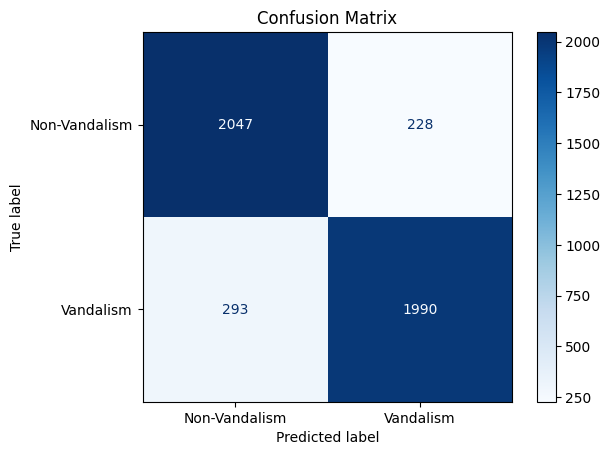

In [109]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate additional statistics
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print statistics
print(f"\nStatistics:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Vandalism', 'Vandalism']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()